In [12]:
from transformer import Transformer
import pandas as pd
import numpy as np
import tqdm
import re
import torch 

#setting up the eviorment
import torch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
from gpytorch.priors import LogNormalPrior
from gpytorch.constraints import Interval

<h2>Loading Split Data</h2>

In [13]:
####Training Set 1#####
# Load the CSV file
training_set_1_df = pd.read_csv('training_set_1.csv')
test_set_1_df = pd.read_csv('test_set_1.csv')

# Access the arrays
z_training_set_1 = training_set_1_df['z_target (m)'].values
TOD_training_set_1 = training_set_1_df['TOD (s^3)'].values
n_protons_train_set_1 = training_set_1_df['n_protons (1/sr)'].values

z_test_set_1 = test_set_1_df['z_target (m)'].values
TOD_test_set_1 = test_set_1_df['TOD (s^3)'].values
n_protons_test_set_1 = test_set_1_df['n_protons (1/sr)'].values

####Training Set 2#####
# Load the CSV file
training_set_2_df = pd.read_csv('training_set_2.csv')
test_set_2_df = pd.read_csv('test_set_2.csv')

# Access the arrays
z_training_set_2 = training_set_2_df['z_target (m)'].values
TOD_training_set_2 = training_set_2_df['TOD (s^3)'].values
n_protons_training_set_2 = training_set_2_df['n_protons (1/sr)'].values

z_test_set_2 = test_set_2_df['z_target (m)'].values
TOD_test_set_2 = test_set_2_df['TOD (s^3)'].values
n_protons_test_set_2 = test_set_2_df['n_protons (1/sr)'].values

<h2>Normalizing Data</h2>

In [14]:
#Setting Bounds
z_bounds = torch.tensor([-150, 150])
TOD_bounds = torch.tensor([-80e3, 80e3])
protons_bounds = torch.tensor([min(n_protons_train_set_1), max(n_protons_train_set_1)])


#define transformers
transformer_z = Transformer(z_bounds.reshape(2,1), transform_type = 'normalize')
transformer_TOD = Transformer(TOD_bounds.reshape(2,1), transform_type = 'normalize')
transformer_n_protons = Transformer(protons_bounds.reshape(2,1), transform_type = 'normalize')


#Full normalization process
def normalization(array, transformer):
    array = np.array(array).reshape(-1,1)
    array = torch.tensor(array)
    norm = transformer.forward(array)
    return norm

In [15]:
# Normalize datasets 1
normed_z_train_set_1 = normalization(z_training_set_1, transformer_z)
normed_TOD_train_set_1 = normalization(TOD_training_set_1, transformer_TOD)
normed_n_train_set_1 = normalization(n_protons_train_set_1, transformer_n_protons)

normed_z_test_set_1 = normalization(z_test_set_1, transformer_z)
normed_TOD_test_set_1 = normalization(TOD_test_set_1, transformer_TOD)
normed_n_test_set_1 = normalization(n_protons_test_set_1, transformer_n_protons)

In [16]:
#Normalize datasets 2
normed_z_train_set_2 = normalization(z_training_set_2, transformer_z)
normed_TOD_train_set_2 = normalization(TOD_training_set_2, transformer_TOD)
normed_n_train_set_2 = normalization(n_protons_training_set_2, transformer_n_protons)

normed_z_test_set_2 = normalization(z_test_set_2, transformer_z)
normed_TOD_test_set_2 = normalization(TOD_test_set_2, transformer_TOD)
normed_n_test_set_2 = normalization(n_protons_test_set_2, transformer_n_protons)

<Figure size 640x480 with 0 Axes>

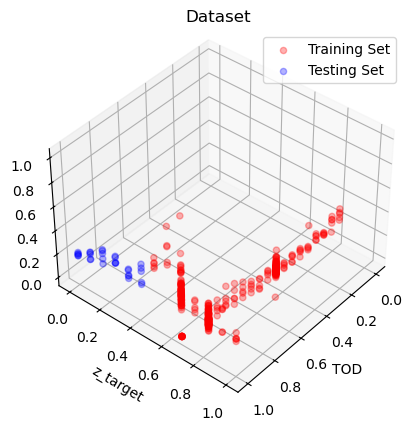

In [17]:
plt.clf()
ax = plt.figure().add_subplot(projection='3d')

ax.scatter( normed_TOD_train_set_1, normed_z_train_set_1,normed_n_train_set_1, c='r',alpha=0.3, label='Training Set')
ax.scatter( normed_TOD_test_set_1, normed_z_test_set_1,normed_n_test_set_1, c='b', alpha=0.3, label='Testing Set')
ax.view_init(elev=40., azim=40, roll=0)
plt.title('Dataset')
plt.xlabel('TOD')
plt.ylabel('z_target')
plt.legend()

<h1> Guassain Process </h1>

In [18]:
#setting up the eviorment
import numpy
from transformer import Transformer
import torch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean, Mean
from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal

<h1> Defining the Guassain Process </h1>

In [23]:
class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Combine the two inputs into a single tensor
train_x_1 = torch.cat([normed_z_train_set_1, normed_TOD_train_set_1], dim=1)  
train_y_1 = normed_n_train_set_1.squeeze()  # Shape should be (n_samples,)

train_x_2 = torch.cat([normed_z_train_set_2, normed_TOD_train_set_2], dim=1)  
train_y_2 = normed_n_train_set_2.squeeze()  # Shape should be (n_samples,)

# Initialize the likelihood and model
likelihood_1 = GaussianLikelihood()
model_1 = GPModel(train_x_1, train_y_1, likelihood_1)

# Initialize the likelihood and model
likelihood_2 = GaussianLikelihood()
model_2 = GPModel(train_x_2, train_y_2, likelihood_2)

<h1> Training Model </h1>

In [24]:
def train_GP(model, likelihood, train_x, train_y, train_z, training_iterations = 1500):
    inputs = torch.cat([train_x, train_y], dim=1)
    model.train()
    likelihood.train()

    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0097)

    # "Loss" for GPs - the marginal log likelihood
    mll = ExactMarginalLogLikelihood(likelihood, model)

    # Lists to save the values
    losses = []
    lengthscales = []
    noises = []

    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(inputs)
        loss = -mll(output, train_z)
        loss.backward()
        optimizer.step()

        # Save the loss and hyperparameters
        losses.append(loss.item())
        lengthscales.append(model.covar_module.lengthscale.item())
        noises.append(model.likelihood.noise.item())
         
        if (i + 1) % 10 == 0:
            print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item():.3f} ' +
              f'lengthscale: {model.covar_module.lengthscale.item():.3f} ' +
              f'noise: {model.likelihood.noise.item():.3f}')


    # Print the new trainable parameters for the model
    for name, param in model.named_parameters():
        print(f'model {name} : {param}')

In [10]:
train_GP(model_1, likelihood_1, normed_z_train_set_1, normed_TOD_train_set_1, normed_n_train_set_1.squeeze())

Iter 1/200 - Loss: 0.762 lengthscale: 0.693 noise: 0.692
Iter 2/200 - Loss: 0.761 lengthscale: 0.693 noise: 0.690
Iter 3/200 - Loss: 0.760 lengthscale: 0.693 noise: 0.688
Iter 4/200 - Loss: 0.759 lengthscale: 0.693 noise: 0.686
Iter 5/200 - Loss: 0.757 lengthscale: 0.693 noise: 0.685
Iter 6/200 - Loss: 0.756 lengthscale: 0.693 noise: 0.683
Iter 7/200 - Loss: 0.755 lengthscale: 0.693 noise: 0.681
Iter 8/200 - Loss: 0.754 lengthscale: 0.693 noise: 0.680
Iter 9/200 - Loss: 0.753 lengthscale: 0.693 noise: 0.678
Iter 10/200 - Loss: 0.751 lengthscale: 0.693 noise: 0.676
Iter 11/200 - Loss: 0.750 lengthscale: 0.693 noise: 0.675
Iter 12/200 - Loss: 0.749 lengthscale: 0.693 noise: 0.673
Iter 13/200 - Loss: 0.748 lengthscale: 0.694 noise: 0.671
Iter 14/200 - Loss: 0.746 lengthscale: 0.694 noise: 0.670
Iter 15/200 - Loss: 0.745 lengthscale: 0.694 noise: 0.668
Iter 16/200 - Loss: 0.744 lengthscale: 0.694 noise: 0.666
Iter 17/200 - Loss: 0.743 lengthscale: 0.694 noise: 0.665
Iter 18/200 - Loss: 0.7

In [11]:
train_GP(model_2, likelihood_2, normed_z_train_set_2, normed_TOD_train_set_2, normed_n_train_set_2.squeeze())

Iter 1/200 - Loss: 0.761 lengthscale: 0.693 noise: 0.692
Iter 2/200 - Loss: 0.760 lengthscale: 0.693 noise: 0.690
Iter 3/200 - Loss: 0.759 lengthscale: 0.693 noise: 0.688
Iter 4/200 - Loss: 0.758 lengthscale: 0.693 noise: 0.686
Iter 5/200 - Loss: 0.757 lengthscale: 0.693 noise: 0.685
Iter 6/200 - Loss: 0.755 lengthscale: 0.693 noise: 0.683
Iter 7/200 - Loss: 0.754 lengthscale: 0.693 noise: 0.681
Iter 8/200 - Loss: 0.753 lengthscale: 0.693 noise: 0.680
Iter 9/200 - Loss: 0.752 lengthscale: 0.693 noise: 0.678
Iter 10/200 - Loss: 0.750 lengthscale: 0.693 noise: 0.676
Iter 11/200 - Loss: 0.749 lengthscale: 0.693 noise: 0.675
Iter 12/200 - Loss: 0.748 lengthscale: 0.693 noise: 0.673
Iter 13/200 - Loss: 0.747 lengthscale: 0.694 noise: 0.671
Iter 14/200 - Loss: 0.746 lengthscale: 0.694 noise: 0.670
Iter 15/200 - Loss: 0.744 lengthscale: 0.694 noise: 0.668
Iter 16/200 - Loss: 0.743 lengthscale: 0.694 noise: 0.666
Iter 17/200 - Loss: 0.742 lengthscale: 0.694 noise: 0.664
Iter 18/200 - Loss: 0.7

<h1> Evaluating The Model </h1>

In [33]:
# Combine the two inputs into a single tensor for testing
test_x_set_1 = torch.cat([normed_z_test_set_1, normed_TOD_test_set_1], dim=1)   

# Switch model to evaluation mode
model_1.eval()
likelihood_1.eval()
       
# Perform predictions on the test set
with torch.no_grad():
    predictions_set_1 = model_1(test_x_set_1)
    test_mean_prediction_set_1 = predictions_set_1.mean  # Mean prediction
    test_lower_set_1, test_upper_set_1 = predictions_set_1.confidence_region()  # Confidence interval
    
    
"""
# Print or visualize the predictions as needed
print(f"Mean Prediction (Test): {test_mean_prediction_set_1}")
print(f"Lower Confidence Bound (Test): {test_lower_set_1}")
print(f"Upper Confidence Bound (Test): {test_upper_set_1}")
"""

train_x_set_1 = torch.cat([normed_z_train_set_1, normed_TOD_train_set_1], dim=1) 

model_1.eval()
likelihood_1.eval()

# Perform predictions on the training set
with torch.no_grad():
    train_predictions_set_1 = model_1(train_x_set_1)
    train_mean_prediction_set_1 = train_predictions_set_1.mean  # Mean prediction
    train_lower_set_1, train_upper_set_1 = train_predictions_set_1.confidence_region()  # Confidence interval
    
"""
# Print or visualize the predictions as needed
print(f"Mean Prediction (Test): {train_mean_prediction_set_1}")
print(f"Lower Confidence Bound (Test): {train_lower_set_1}")
print(f"Upper Confidence Bound (Test): {train_upper_set_1}")
"""

/global/homes/a/adiaz/.conda/envs/andrea/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


'\n# Print or visualize the predictions as needed\nprint(f"Mean Prediction (Test): {train_mean_prediction_set_1}")\nprint(f"Lower Confidence Bound (Test): {train_lower_set_1}")\nprint(f"Upper Confidence Bound (Test): {train_upper_set_1}")\n'

In [35]:
# Combine the two inputs into a single tensor for testing
test_x_set_2 = torch.cat([normed_z_test_set_2, normed_TOD_test_set_2], dim=1)   
# Switch model to evaluation mode
model_2.eval()
likelihood_2.eval()
       
# Perform predictions on the test set
with torch.no_grad():
    predictions_set_2 = model_2(test_x_set_2)
    test_mean_prediction_set_2 = predictions_set_2.mean  # Mean prediction
    test_lower_set_2, test_upper_set_2 = predictions_set_2.confidence_region()  # Confidence interval
    
    
    
train_x_set_2 = torch.cat([normed_z_train_set_2, normed_TOD_train_set_2], dim=1) 

model_2.eval()
likelihood_2.eval()

# Perform predictions on the training set
with torch.no_grad():
    train_predictions_set_2 = model_2(train_x_set_2)
    train_mean_prediction_set_2 = train_predictions_set_2.mean  # Mean prediction
    train_lower_set_2, train_upper_set_2 = train_predictions_set_2.confidence_region()  # Confidence interval


<h1> Visualization </h1>

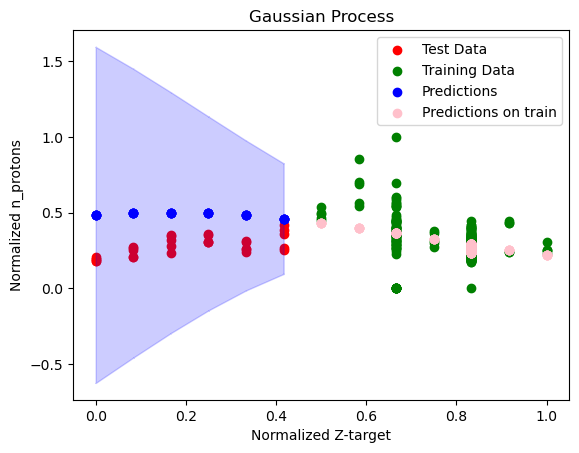

In [38]:

plt.figure()

# Scatter plot of the actual test data
plt.scatter(normed_z_test_set_1.numpy(), normed_n_test_set_1.numpy(), c='r', label='Test Data')
plt.scatter(normed_z_train_set_1.numpy(), normed_n_train_set_1.numpy(), c='g', label='Training Data')

plt.scatter(normed_z_test_set_1.numpy(), test_mean_prediction_set_1.numpy(), c='b', label='Predictions')
plt.scatter(normed_z_train_set_1.numpy(), train_mean_prediction_set_1.numpy(), c='pink', label='Predictions on train')

plt.xlabel('Normalized Z-target')
plt.ylabel('Normalized n_protons')
plt.title('Gaussian Process')
plt.legend()

# Fill between the prediction intervals
plt.fill_between(normed_z_test_set_1.squeeze().numpy(), test_lower_set_1.numpy(), test_upper_set_1.numpy(), alpha=0.2, color='b', label='Confidence Interval')
# Show the plot
plt.savefig("GP_A.png")
plt.show()

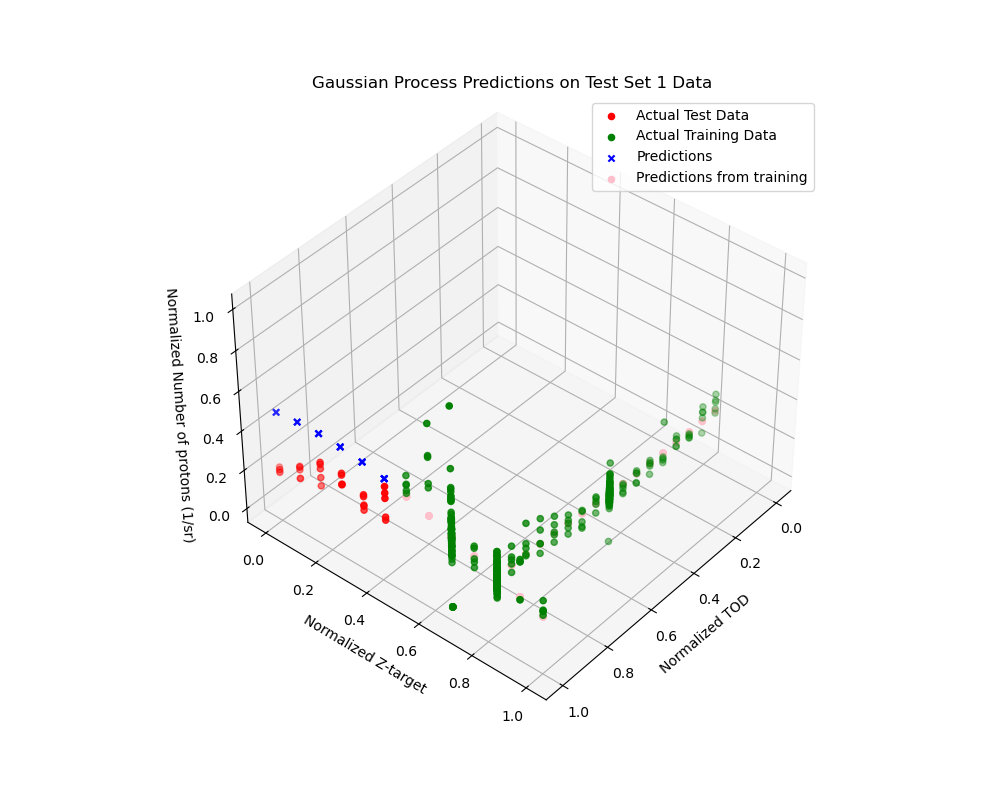

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the actual test data
ax.scatter(normed_TOD_test_set_1.numpy(), normed_z_test_set_1.numpy(), normed_n_test_set_1.numpy(), c='r', label='Actual Test Data')

# Scatter plot of the training data
ax.scatter(normed_TOD_train_set_1.numpy(), normed_z_train_set_1.numpy(), normed_n_train_set_1.numpy(), c='g', label='Actual Training Data')

# Scatter plot of the predictions
ax.scatter(normed_TOD_test_set_1.numpy(), normed_z_test_set_1.numpy(), test_mean_prediction_set_1.numpy(), c='b', marker='x', label='Predictions')

# Scatter plot of the predictions
ax.scatter(normed_TOD_train_set_1.numpy(), normed_z_train_set_1.numpy(), train_mean_prediction_set_1.numpy(), c='pink', label='Predictions from training')


ax.view_init(elev=40, azim=40, roll=0)
# Labels and legend
ax.set_xlabel('Normalized TOD')
ax.set_ylabel('Normalized Z-target')
ax.set_zlabel('Normalized Number of protons (1/sr)')
ax.set_title('Gaussian Process Predictions on Test Set 1 Data')
ax.legend()

plt.savefig("GP_adam.png")
plt.show()

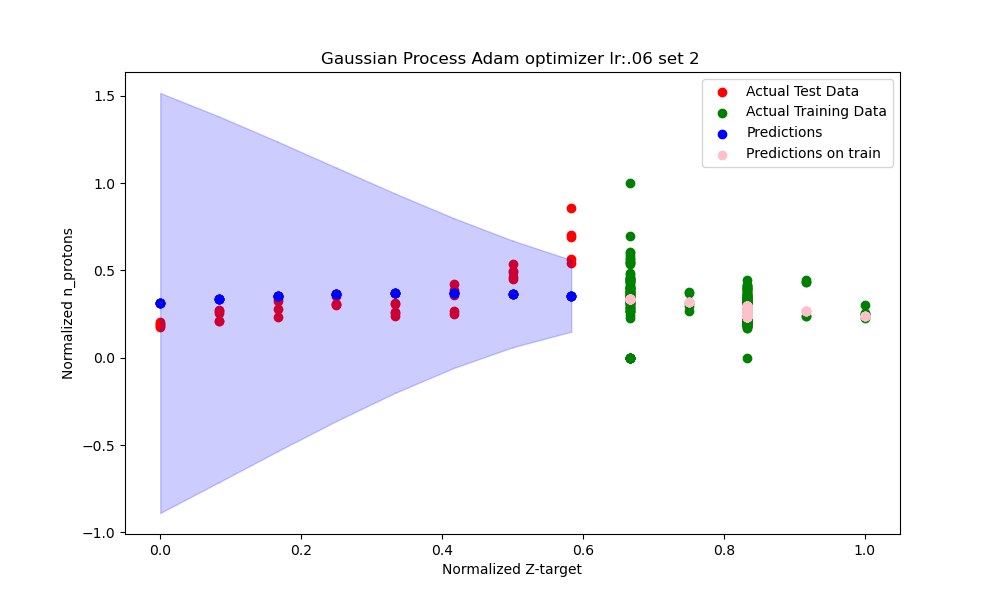

In [40]:
# Example plotting (requires matplotlib)
plt.figure(figsize=(10, 6))

# Scatter plot of the actual test data
plt.scatter(normed_z_test_set_2.numpy(), normed_n_test_set_2.numpy(), c='r', label='Actual Test Data')
plt.scatter(normed_z_train_set_2.numpy(), normed_n_train_set_2.numpy(), c='g', label='Actual Training Data')

plt.scatter(normed_z_test_set_2.numpy(), test_mean_prediction_set_2.numpy(), c='b', label='Predictions')
plt.scatter(normed_z_train_set_2.numpy(), train_mean_prediction_set_2.numpy(), c='pink', label='Predictions on train')

plt.xlabel('Normalized Z-target')
plt.ylabel('Normalized n_protons')
plt.title('Gaussian Process Adam optimizer lr:.06 set 2 ')
plt.legend()

# Fill between the prediction intervals
plt.fill_between(normed_z_test_set_2.squeeze().numpy(), test_lower_set_2.numpy(), test_upper_set_2.numpy(), alpha=0.2, color='b', label='Confidence Interval')
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the actual test data
ax.scatter(normed_TOD_test_set_2.numpy(), normed_z_test_set_2.numpy(), normed_n_test_set_2.numpy(), c='r', label='Actual Test Data')

# Scatter plot of the training data
ax.scatter(normed_TOD_train_set_2.numpy(), normed_z_train_set_2.numpy(), normed_n_train_set_2.numpy(), c='g', label='Actual Training Data')

# Scatter plot of the predictions
ax.scatter(normed_TOD_test_set_2.numpy(), normed_z_test_set_2.numpy(), test_mean_prediction_set_2.numpy(), c='b', marker='x', label='Predictions')

# Scatter plot of the predictions
ax.scatter(normed_TOD_train_set_1.numpy(), normed_z_train_set_1.numpy(), train_mean_prediction_set_1.numpy(), c='pink', label='Predictions from training')


ax.view_init(elev=40, azim=40, roll=0)
# Labels and legend
ax.set_xlabel('Normalized TOD')
ax.set_ylabel('Normalized Z-target')
ax.set_zlabel('Normalized Number of protons (1/sr)')
ax.set_title('Gaussian Process Predictions on Test Set 1 Data')
ax.legend()

plt.savefig("GP_adam.png")
plt.show()

In [ ]:
iterations = range(1, training_iterations + 1)

plt.figure()
# Plot loss
plt.scatter(iterations, losses, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.legend()


plt.savefig("Loss_vs_iterations.png")
plt.show()

In [ ]:
iterations = range(1, training_iterations + 1)
plt.figure()
plt.scatter(iterations, lengthscales, label='Lengthscale', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Lengthscale')
plt.title('Lengthscale vs Iterations')
plt.legend()
plt.tight_layout()

plt.savefig("length_vs_iterations.png")
plt.show()

In [ ]:
iterations = range(1, training_iterations + 1)

# Plot noise
plt.figure(figsize=(6, 4))
plt.scatter(iterations, noises, label='Noise', color='green')
plt.xlabel('Iteration')
plt.ylabel('Noise')
plt.title('Noise vs Iterations')
plt.legend()
plt.tight_layout()

plt.savefig("Noise_vs_iterations.png")
plt.show()